In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

In [2]:
column_names = ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

In [3]:
dataset = pd.read_csv("D:/seminar/DZ_2/dataset/user_behavior_dataset.csv",  sep = ",", skipinitialspace=True, low_memory=False)
dataset.head(10)

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3
5,6,Google Pixel 5,Android,99,2.0,940,35,564,31,Male,2
6,7,Samsung Galaxy S21,Android,350,7.3,1802,66,1054,21,Female,4
7,8,OnePlus 9,Android,543,11.4,2956,82,1702,31,Male,5
8,9,Samsung Galaxy S21,Android,340,7.7,2138,75,1053,42,Female,4
9,10,iPhone 12,iOS,424,6.6,1957,75,1301,42,Male,4


In [4]:
print("#samples = ", dataset.shape[0])
print("#features = ", dataset.shape[1])

#samples =  700
#features =  11


In [5]:
# no missing values
dataset[dataset.eq("?").any(axis=1)].head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class


In [6]:
# manage metadata
def get_metadata(data):
    metadata = data.columns
    numerical_cols = data.select_dtypes(include = ["float64", "int64"]).columns.tolist()
    categorical_cols = data.select_dtypes(include = ["object"]).columns.tolist()
    print("Numerical features: ", numerical_cols)
    print("Categorical features: ", categorical_cols)
    return metadata, numerical_cols, categorical_cols

In [7]:
metadata, numeric_cols, categ_cols = get_metadata(dataset)

Numerical features:  ['User ID', 'App Usage Time (min/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 'Number of Apps Installed', 'Data Usage (MB/day)', 'Age', 'User Behavior Class']
Categorical features:  ['Device Model', 'Operating System', 'Gender']


Descriptive Statistical Analysis

In [8]:
def hist_frequencies(data, column, bins):
    sbn.histplot(data[column], color = "blue", bins = bins)
    plt.xlabel(column)
    plt.ylabel("Frequencies")
    plt.title("Histogram distribution for " + column)
    plt.show()

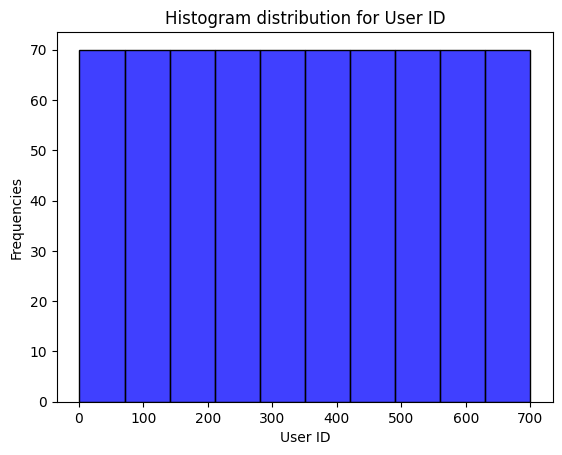

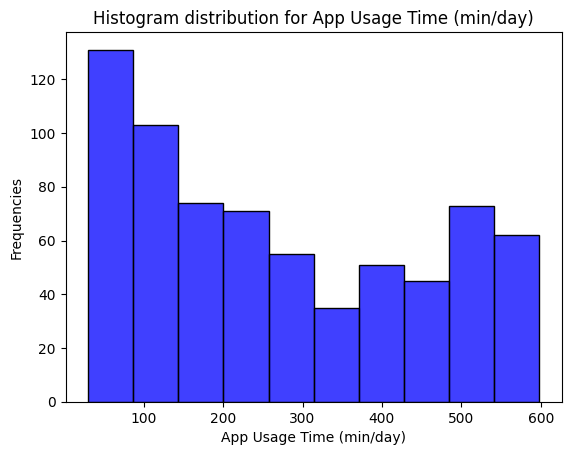

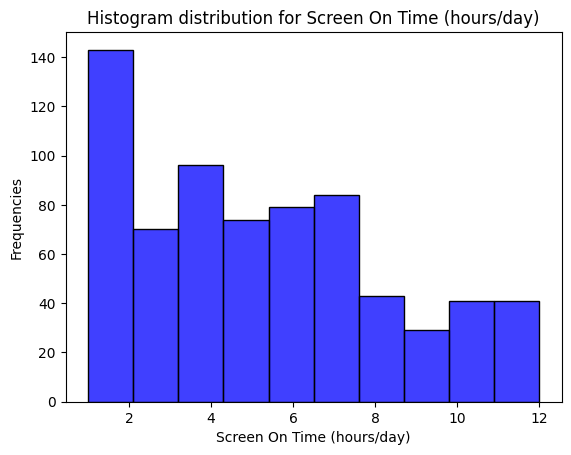

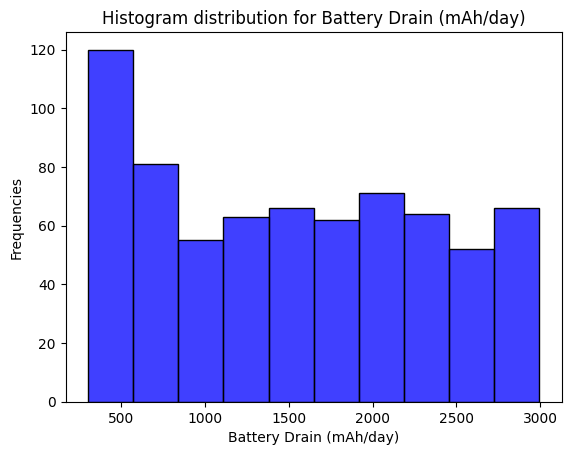

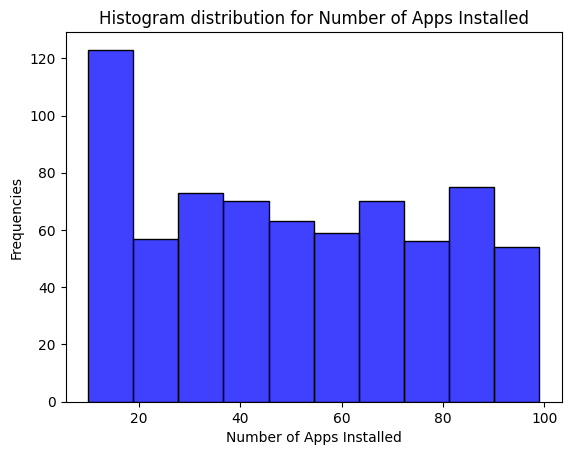

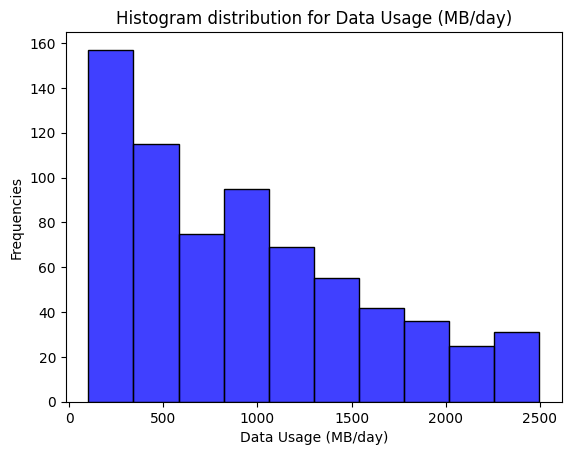

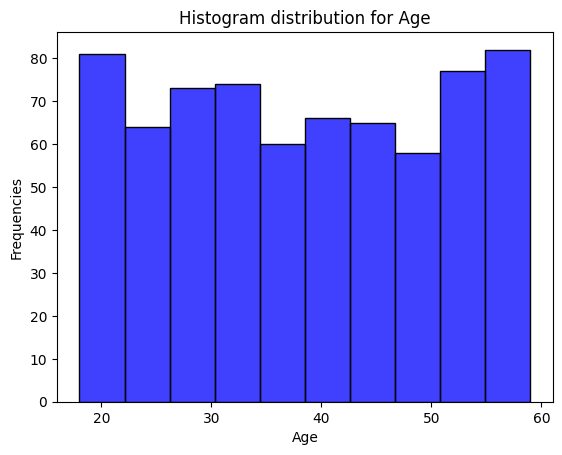

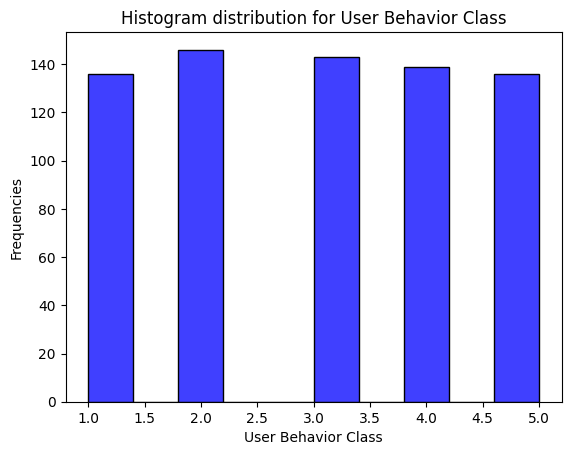

In [9]:
# plot the distribution for each numerical column
for col in numeric_cols:
    hist_frequencies(dataset, col, 10)

Based on the histograms, we can say that on average, users spend a little time using applications and screen activity (from 2 to 4 hours a day). In addition, many of them are limited to a smaller number of installed applications (about 20), although there are groups with a higher number of installations and a longer duration of use.

In [10]:
# function to plot distribution for 1 numerical column
def hist_density(data, column, bins):
    sbn.histplot(data[column], color = "blue", bins = bins, kde = False, stat = "density", alpha = 0.5)
    sbn.kdeplot(data[column], color = "red", linewidth = 2)
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.title("Histogram and KDE for " + column)    
    plt.show()

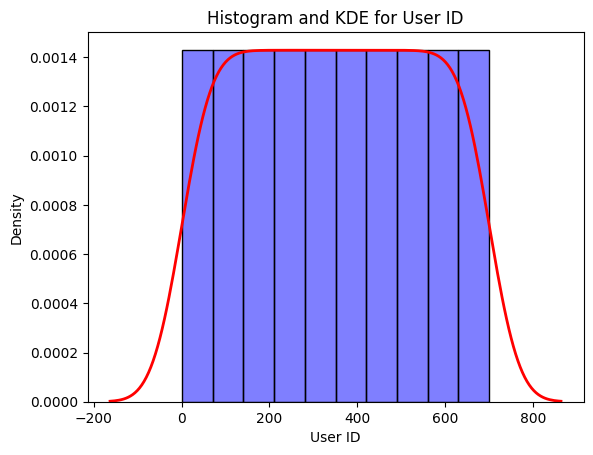

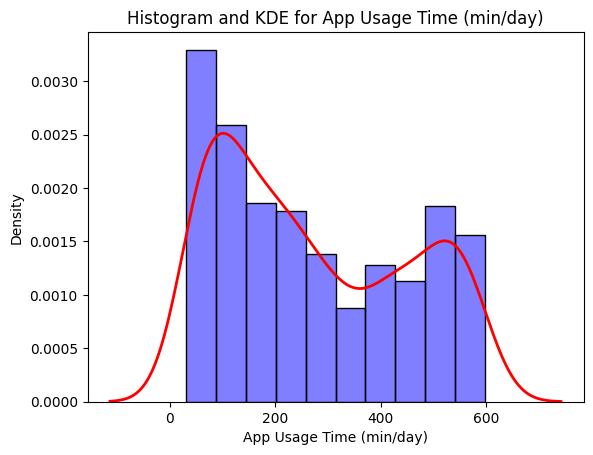

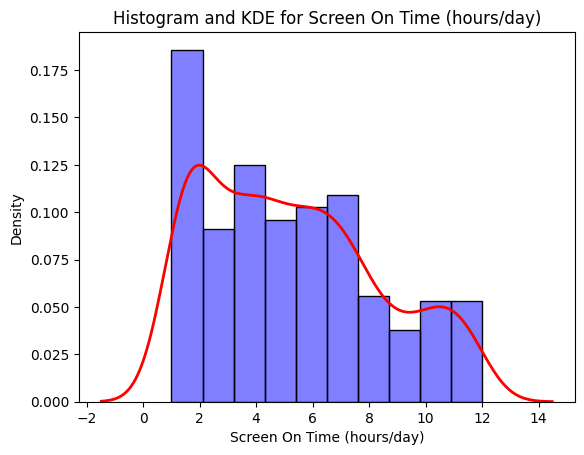

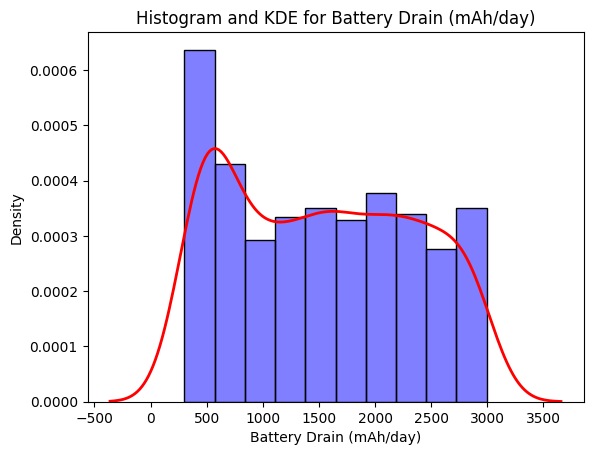

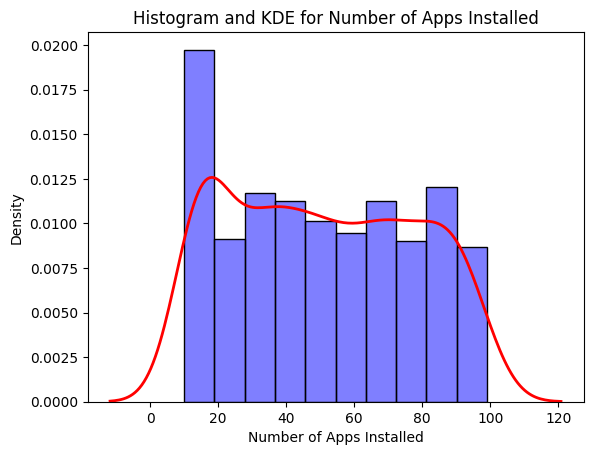

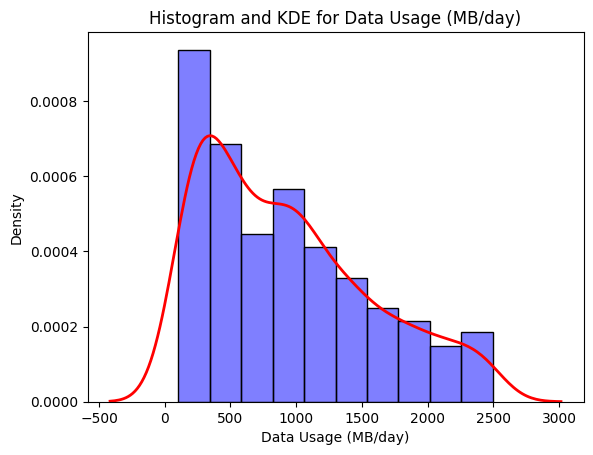

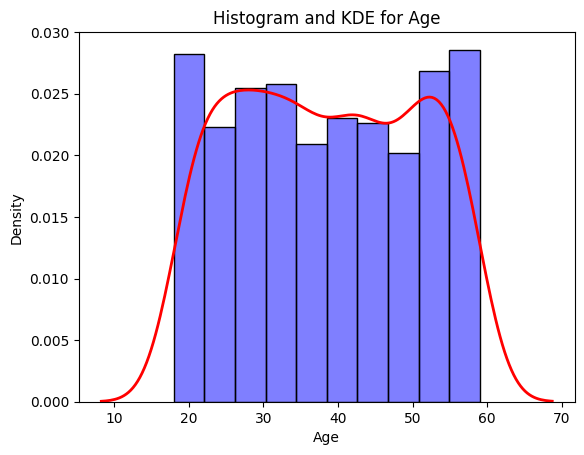

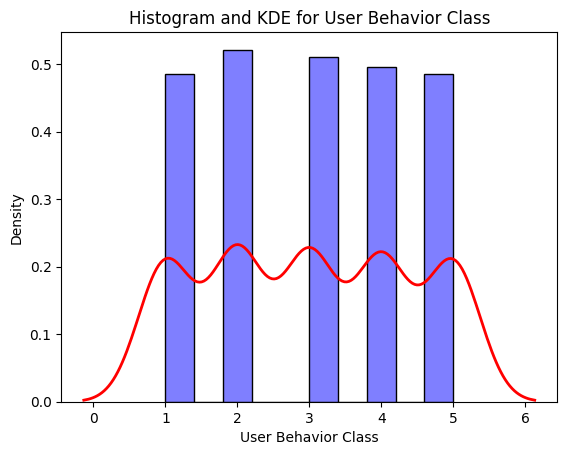

In [11]:
for col in numeric_cols:
    hist_density(dataset, col, 10)

The graphs show that there are some jumps in the function that are poorly reflected in the bar graph, but this is not critical

In [12]:
# function to make boxplot
def statistics_nvar(data, numerical_cols):
    # calculate the nrows and ncols for plots
    ncol_plots = 2
    nrow_plots = (len(numerical_cols) + ncol_plots - 1) // ncol_plots
    # create the subplots for specific row and column
    fig, axs = plt.subplots(nrow_plots, ncol_plots, figsize = (16, 4 * nrow_plots))
    axs = axs.flatten()
    # create boxplots for each numerical column
    for i, col in enumerate(numerical_cols):
        sbn.boxplot(data[col], ax = axs[i])
        axs[i].set_title("Box plot for " + col)
    plt.tight_layout()
    plt.show()

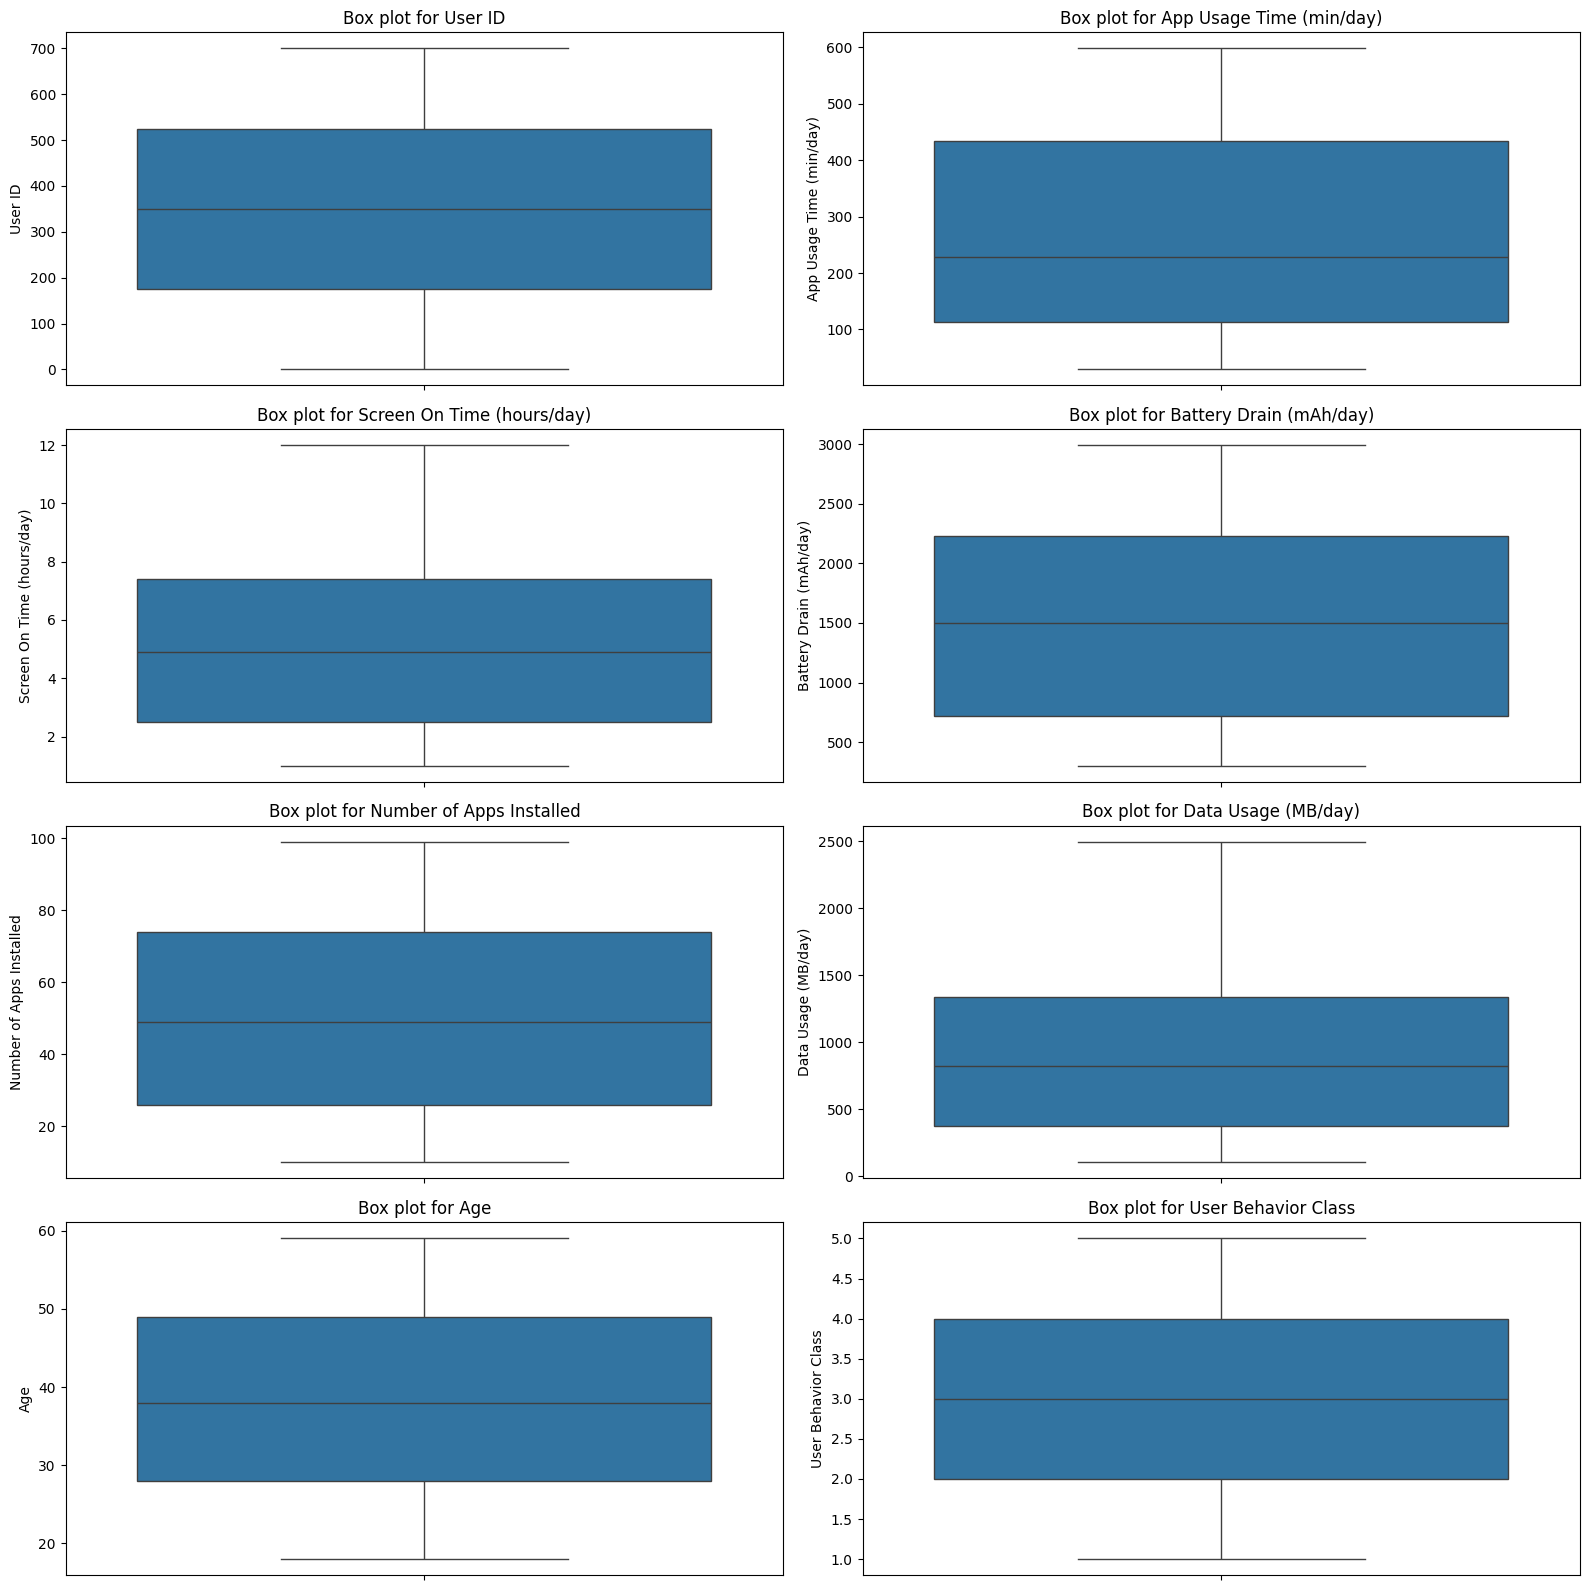

In [13]:
# boxplot for each numerical column
statistics_nvar(dataset, numeric_cols)

The box plot helps in visualizing the central tendency (median), data spread (IQR), and the presence of outliers in each numerical column.

In [14]:
## function to plot correlation between numerical variables
def plot_correlation(data, cols):
    corr = data[cols].corr()
    plt.matshow(corr, cmap = "coolwarm")
    plt.xticks(range(len(cols)), cols, rotation = 90)
    plt.yticks(range(len(cols)), cols)

    # add the correlation values in each cell
    for (i, j), val in np.ndenumerate(corr):
        plt.text(j, i, f"{val:.1f}", ha='center', va='center', color='black')
    plt.title("Correlation Analysis")
    plt.colorbar()    
    plt.show()

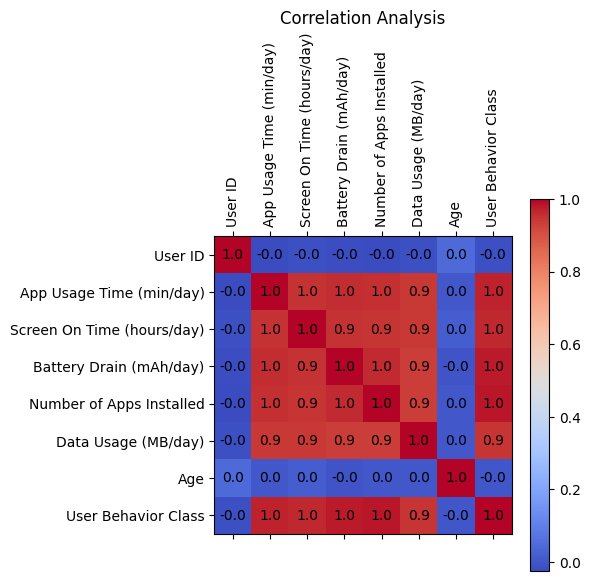

In [15]:
plot_correlation(dataset, numeric_cols)

The values inside each cell represent the Pearson correlation coefficient, ranging from -1 (strong negative correlation) to +1 (strong positive correlation), with 0 indicating no correlation.


In [16]:
from scipy import stats

# Function for outliers detection based on percentiles
def outliers_detection(dataset, col, lower_percentile=2.275, upper_percentile=97.725):
    lower_bound = dataset[col].quantile(lower_percentile / 100)
    upper_bound = dataset[col].quantile(upper_percentile / 100)
    # Filter out the outliers
    outliers = dataset[(dataset[col] < lower_bound) | (dataset[col] > upper_bound)]
    return outliers

In [17]:
for col in numeric_cols:
    print("\n*** Outliers detection in " + col + " ***")
    lst_outliers = outliers_detection(dataset, col)
    print(f"#samples outlier to distribution = {len(lst_outliers)}")
    print(f"%outliers = {round(100* len(lst_outliers)/len(dataset), 2)} %")


*** Outliers detection in User ID ***
#samples outlier to distribution = 32
%outliers = 4.57 %

*** Outliers detection in App Usage Time (min/day) ***
#samples outlier to distribution = 31
%outliers = 4.43 %

*** Outliers detection in Screen On Time (hours/day) ***
#samples outlier to distribution = 15
%outliers = 2.14 %

*** Outliers detection in Battery Drain (mAh/day) ***
#samples outlier to distribution = 32
%outliers = 4.57 %

*** Outliers detection in Number of Apps Installed ***
#samples outlier to distribution = 31
%outliers = 4.43 %

*** Outliers detection in Data Usage (MB/day) ***
#samples outlier to distribution = 29
%outliers = 4.14 %

*** Outliers detection in Age ***
#samples outlier to distribution = 24
%outliers = 3.43 %

*** Outliers detection in User Behavior Class ***
#samples outlier to distribution = 0
%outliers = 0.0 %


Categorical Variables

In [18]:
# cycle to calculate number of instances in each categorical column
for col in categ_cols:
    print("\n***** " + col + " ******")
    print(dataset[col].value_counts())


***** Device Model ******
Device Model
Xiaomi Mi 11          146
iPhone 12             146
Google Pixel 5        142
OnePlus 9             133
Samsung Galaxy S21    133
Name: count, dtype: int64

***** Operating System ******
Operating System
Android    554
iOS        146
Name: count, dtype: int64

***** Gender ******
Gender
Male      364
Female    336
Name: count, dtype: int64


Data imputation with K-Nearest Neighbors (KNN)

In [19]:
# function to plot bar chart for absolute frequencies in 1 categorical column
def plot_barchart(dataset, col):
    results = dataset[col].value_counts().head(30)
    sbn.barplot(x = results.values.tolist(), y = results.index.tolist(), orient = "y")
    plt.title("Statistical analysis by " + col)
    plt.show()

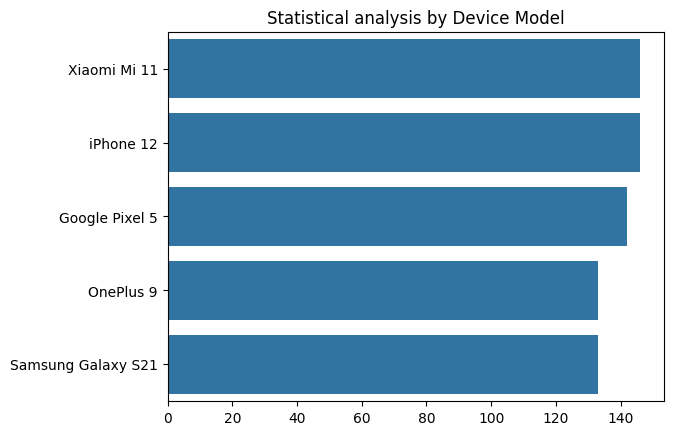

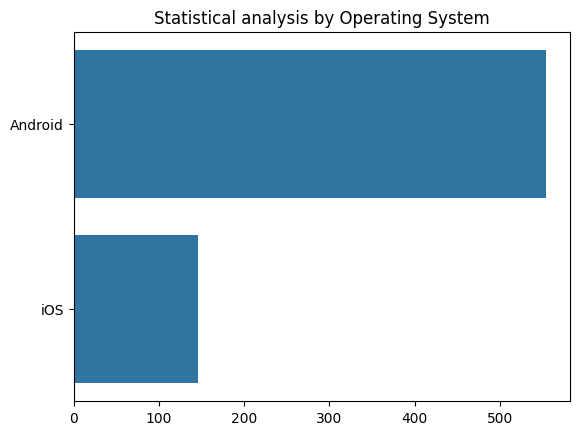

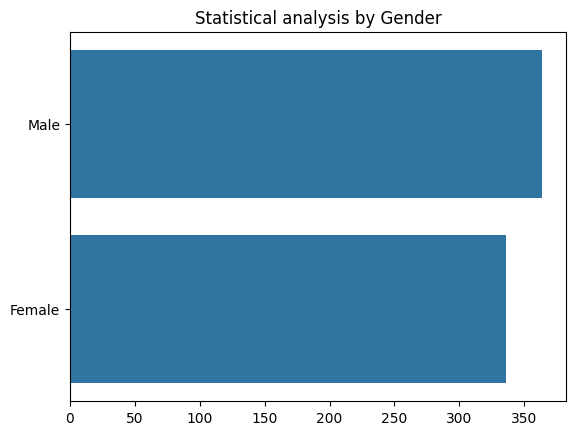

In [20]:
# cycle to plot bar chart for each categorical column
for col in categ_cols:
    plot_barchart(dataset, col)

Exploration of Data after Imputation

In [21]:
# function to plot pie chart for relative frequencies in 1 categorical column
def plot_piechart(dataset, col):
    # count the #samples for each categogy
    results = dataset[col].value_counts()
    # calculate the relative frequencies
    total_samples = results.sum()
    rel_freq = results/total_samples
    sbn.set_style("whitegrid")
    plt.figure(figsize=(6,6))
    plt.pie(rel_freq.values.tolist(), labels = rel_freq.index.tolist(), autopct='%1.1f%%')
    plt.title("Relative frequency analysis by " + col)
    plt.show()

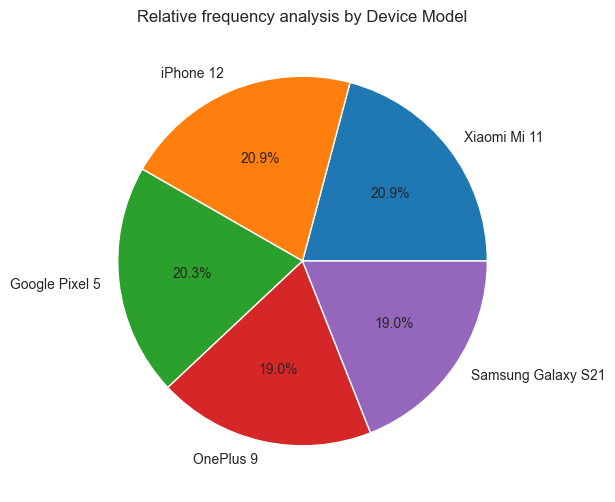

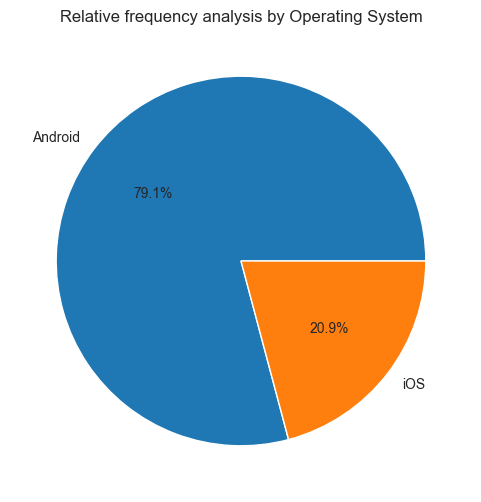

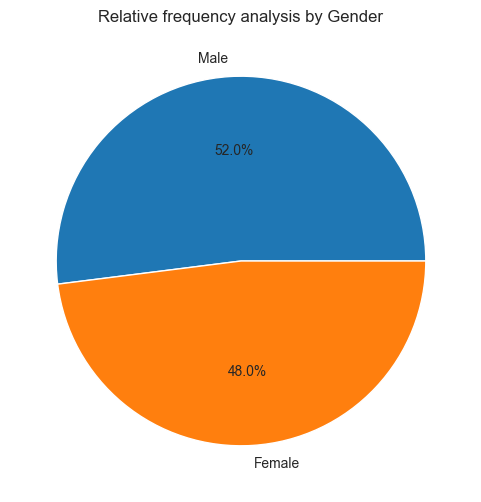

In [22]:
# cycle to plot pie chart
for col in categ_cols:
    plot_piechart(dataset, col)

The pie chart helps in understanding the proportion of different categories in the data. 

Statistical Analysis for subgroups

In [23]:
# create groups organized 
group_gender_income = dataset.groupby(["Operating System", "Gender"]).size().reset_index(name = "samples")
print(group_gender_income)

  Operating System  Gender  samples
0          Android  Female      262
1          Android    Male      292
2              iOS  Female       74
3              iOS    Male       72


In [24]:
# function to plot absolute frequencies for groups
def plot_absfreq_groups(group, g1, g2):
    sbn.barplot(data = group, x = g1, y = "samples", hue = g2, palette = "pastel")
    plt.xlabel('Gender')
    plt.ylabel('Absolute Frequencies')
    plt.title('Bar Chart of Absolute Frequencies by Gender and Operating System')
    plt.tight_layout()
    plt.show()

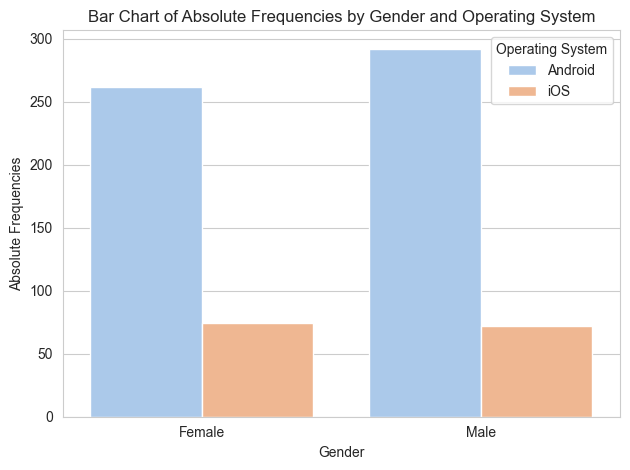

In [25]:
plot_absfreq_groups(group_gender_income, "Gender", "Operating System")

In [26]:
# function to plot relative frequencies for groups
def plot_relfreq_groups(group, g1, g2):
    labels = group[g1] + ' ' + group[g2]
    sizes = group["samples"]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Pie Chart of Relative Frequencies by Gender and Operating System')
    plt.show()

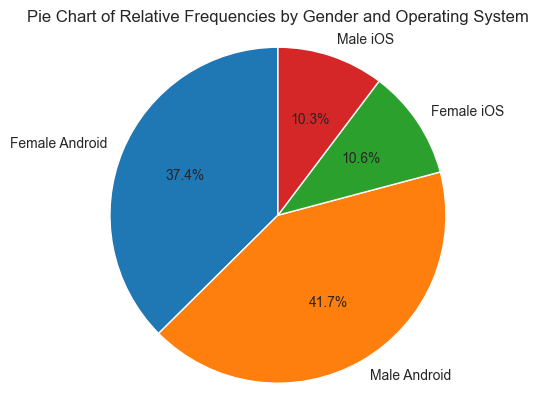

In [27]:
plot_relfreq_groups(group_gender_income, "Gender", "Operating System")

КОМЕНТАРИИ

In [28]:
# create groups organized by Gender Group 

group_income = dataset.groupby(["Gender", "Operating System"]).size().reset_index(name = "samples")
print(group_income)

   Gender Operating System  samples
0  Female          Android      262
1  Female              iOS       74
2    Male          Android      292
3    Male              iOS       72


Split train and test set

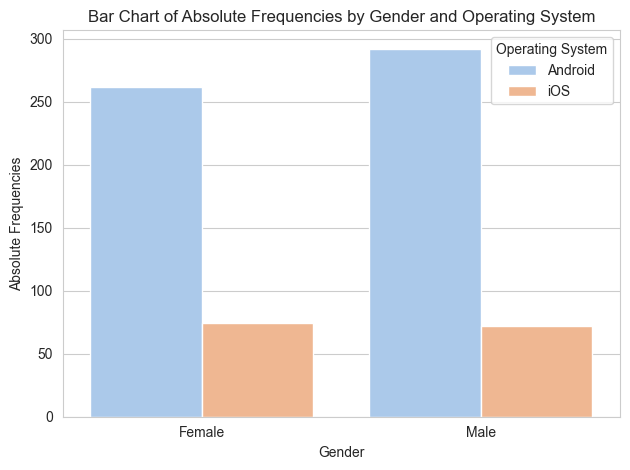

In [29]:
plot_absfreq_groups(group_income, "Gender", "Operating System")

Transforming the numerical and categorical data

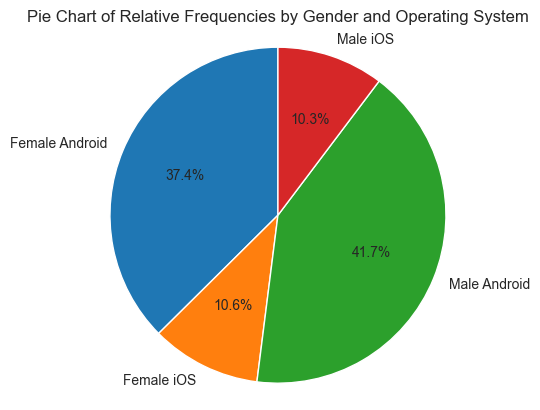

In [30]:
plot_relfreq_groups(group_income, "Gender", "Operating System")